In [368]:
import numpy as np
from scipy.io import wavfile
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlation_lags
from scipy.optimize import minimize



In [369]:
my_file = 'B_S2_D1_067-bebop_000_.wav'

In [370]:
sample_rate, data =  wavfile.read(my_file)


In [371]:
measurement_distance = 10.0

# Read the original recording and create an array with the time of each sample
sample_rate, sample=  wavfile.read(my_file)
sample = np.tile(sample, 10)



sample_length = len(sample)
sample_duration = sample_length/sample_rate
print("The original sample is ", sample_duration, " long")
sample_time = np.linspace(0.0, sample_duration, sample_length)

# Configure our soundscape
speed_of_sound = 343
source_start = np.asarray([80.0, 75.0, 0.0])

# TODO: We currently assume that things are moving with constant velocity. But this needs to change to a general
# trajectory defined through coordinates.

velocity = np.broadcast_to([[5.0, 5.0, 0.0]], (sample_length, 3))
position = source_start + velocity * (sample_time - sample_time[0])[:, np.newaxis]
mic_locs = np.asarray([
    [0.0, 0.0, 0.0],
    [300.0, 0.0, 0.0],
    [0.0, 300.0, 0.0],
    [300.0, 300.0, 0.0]
])
num_mics = mic_locs.shape[0]

# Calculate the arrival times for each microphone -- 
unit_vectors = mic_locs - position[:, np.newaxis, :]
unit_vectors /= np.linalg.norm(unit_vectors, axis=2, keepdims=True)

# This einsum is basically a dot product between the velocity and the unit vectors
# for each point in time
#  we compute the approach speed as follows -- project the velocity at time t of the donre
# with the unit vector between its current position and the locations of all the microphones
approach_speeds = np.einsum('ij,ikj->ik', velocity, unit_vectors)

# Compute all the distances between the microphones and the drone
distances = cdist(position, mic_locs)

damping_ratio = measurement_distance**2/(1.0 + distances)**2

#arrival time  = distance / speed of propagation,  which is approach_speed + speed of sound.
arrival_times = sample_time[:, np.newaxis] + distances / (approach_speeds + speed_of_sound)

arrival_min_overall = arrival_times.min()
arrival_max_overall = arrival_times.max()

# Resample the original recording to get the synthetic recordings
recordings_start = arrival_times.min()
recordings_end = arrival_times.max()
recording_length = recordings_end - recordings_start
recording_samples = int(recording_length * sample_rate)
recordings = np.zeros((num_mics, recording_samples))
recordings_time = np.linspace(recordings_start, recordings_end, recording_samples)

for i in range(num_mics):
    recordings[i, :] = np.interp(recordings_time, arrival_times[:, i], damping_ratio[:,i]*sample, left=0, right=0)

The original sample is  10.24  long


In [422]:
wavfile.write("longer.wav", sample_rate, sample)
wavfile.write("microphone1.wav", sample_rate, recordings[0])
wavfile.write("microphone2.wav", sample_rate, recordings[1])
wavfile.write("microphone3.wav", sample_rate, recordings[2])
wavfile.write("microphone4.wav", sample_rate, recordings[3])

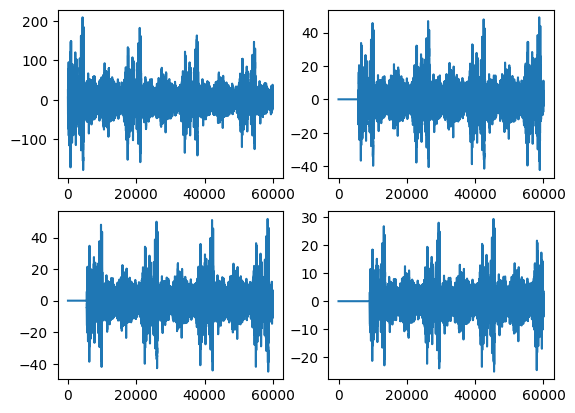

In [373]:
fig, axs  = plt.subplots(2,2)
axs[0,0].plot(recordings[0,:60000] )
axs[1,0].plot(recordings[1,:60000] )
axs[0,1].plot(recordings[2,:60000] )
axs[1,1].plot(recordings[3,:60000] )

In [374]:
def estimate_tdoa(signals, fs, ref=0):
    """
    Estimates the Time Difference of Arrival (TDOA) between multiple signals.
    
    Parameters:
        signals (numpy array): Recorded signals from each microphone.
        fs (int): Sampling frequency.
    
    Returns:
        list: Estimated TDOAs in seconds between the first microphone and others.
    """
    num_mics = signals.shape[0]    
    tdoas = np.zeros(num_mics)

    ref_signal = signals[ref,:]
    for i in range(num_mics):
        correlation = correlate(ref_signal, signals[i,:])
        lags = correlation_lags(len(ref_signal), len(signals[i,:]))
        delay_samples = lags[np.argmax(correlation)]
        tdoas[i] = delay_samples / fs
    
    return tdoas


# This estimates the time delay of arrival at a given time, using a window of the form
# [window/2 - t , window/2 + t]
def estimate_windowed_tdoa(signals, t, window, fs, ref=0):
    """
    Estimates the Time Difference of Arrival (TDOA) between multiple signals.
    
    Parameters:
        signals (numpy array): Recorded signals from each microphone.
        fs (int): Sampling frequency.
    
    Returns:
        list: Estimated TDOAs in seconds between the first microphone and others.
    """
    num_mics = signals.shape[0]    
    tdoas = np.zeros(num_mics)

    left = max(0, t - window//2)
    right = min(signals.shape[1], t + window//2)

    ref_signal = signals[ref,left:right]
    for i in range(num_mics):
        correlation = correlate(ref_signal, signals[i,left:right])
        lags = correlation_lags(len(ref_signal), len(signals[i,left:right]))
        delay_samples = lags[np.argmax(correlation)]
        tdoas[i] = delay_samples / fs
    
    return tdoas

In [413]:
#### Compute windowed tdoa array over a set of time slices

def generate_readings_over_time(samples, window_size, sample_rate, subsample=100):
    arr = []
    for i in range(0, samples.shape[1],subsample):
        arr = arr + [estimate_windowed_tdoa(samples, i, window_size, sample_rate)]

    # generate this to be consistent
    pos_sub = position[::subsample, :]

    # generate time points
    ts = np.arange(pos_sub.shape[0])/(subsample*sample_rate)
    return np.array(arr), pos_sub, ts

tdoa_windows, pos_sub, t_sub = generate_readings_over_time(recordings, 2*sample_rate, sample_rate, 100)


In [406]:
def localization_loss_function(source_position, mic_positions, tdoas, c):
    predictions = np.zeros(len(tdoas))
    d_ref = np.linalg.norm(source_position - mic_positions[0,:])

    for i in range(len(tdoas)):
        d_i = np.linalg.norm(source_position - mic_positions[i,:])
        predictions[i] = d_ref - d_i

    r = np.sum(np.abs(predictions - c * tdoas))
    return r 

In [407]:

def localize_emitter(mic_positions, tdoas, c=343.0):
    """
    Localizes the source using TDOA measurements and microphone positions.
    
    Parameters:
        mic_positions (numpy array): Array of microphone positions [(x1, y1), (x2, y2), ...]
        tdoas (list): Time differences of arrival from the reference microphone to each microphone (s)
        c (float): Speed of sound in the medium (m/s)
    
    Returns:
        numpy array: Estimated source position (x, y)
    """
    initial_guess = np.mean(mic_positions, axis=0)
    print("Initial Guess : ", initial_guess)
    result = minimize(localization_loss_function, initial_guess, args=(mic_positions, tdoas, c), bounds=([0.0, 300.0], [0.0, 300.0, ], [-np.inf, np.inf]))
    return result.x

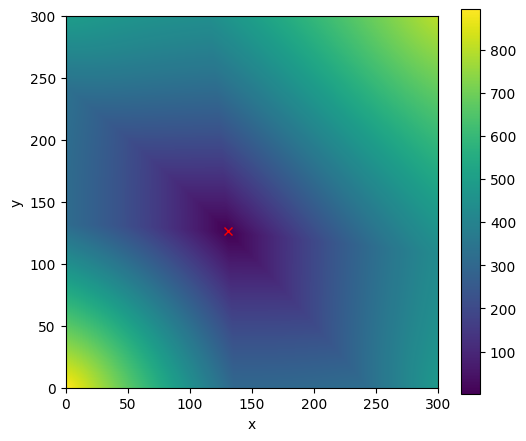

In [408]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for x and y
x = np.linspace(0, 300, 400)
y = np.linspace(0, 300, 400)

# Create a meshgrid
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = localization_loss_function(np.array([X[i,j], Y[i,j], 0.0]), mic_locs, tdoa_windows[-1,:], speed_of_sound)
        
# Plotting
plt.figure(figsize=(6, 5))
plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.colorbar()  # Show the color scale
plt.xlabel('x')
plt.ylabel('y')
plt.plot(pos_sub[-1,0], pos_sub[-1, 1], 'x', color='red')
plt.show()


In [402]:
location_guess = localize_emitter(mic_locs,tdoa_windows[-1,:])

Initial Guess :  [150. 150.   0.]


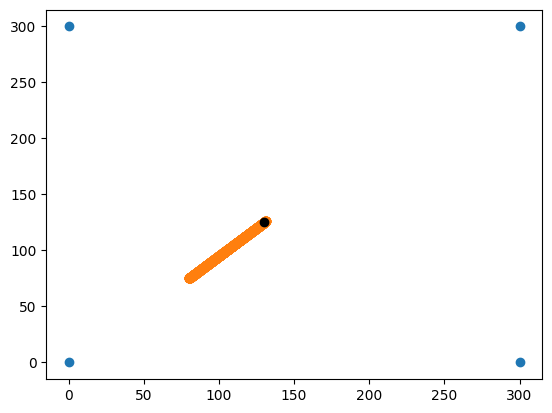

In [403]:
mic_locs_arr = np.array(mic_locs)
plt.scatter(mic_locs_arr[:,0], mic_locs_arr[:,1])
plt.scatter(pos_sub[:,0], pos_sub[:,1])
plt.plot(location_guess[0], location_guess[1], 'o', color='black')


In [419]:
predictions = []

# for loop to demo
for i in range(pos_sub.shape[0]):
    location_guess = localize_emitter(mic_locs,tdoa_windows[i,:])
    print("At time : ", t_sub[i], " we predict location of drone at ", location_guess, ". Actual position is ", pos_sub[i,:])
    predictions = predictions + [location_guess]

predictions = np.array(predictions)

Initial Guess :  [150. 150.   0.]
At time :  0.0  we predict location of drone at  [83.17806522 79.33574431  0.        ] . Actual position is  [80. 75.  0.]
Initial Guess :  [150. 150.   0.]
At time :  6.25e-07  we predict location of drone at  [83.17806522 79.33574431  0.        ] . Actual position is  [80.03125019 75.03125019  0.        ]
Initial Guess :  [150. 150.   0.]
At time :  1.25e-06  we predict location of drone at  [83.17806522 79.33574431  0.        ] . Actual position is  [80.06250038 75.06250038  0.        ]
Initial Guess :  [150. 150.   0.]
At time :  1.875e-06  we predict location of drone at  [83.17806522 79.33574431  0.        ] . Actual position is  [80.09375057 75.09375057  0.        ]
Initial Guess :  [150. 150.   0.]
At time :  2.5e-06  we predict location of drone at  [83.17806522 79.33574431  0.        ] . Actual position is  [80.12500076 75.12500076  0.        ]
Initial Guess :  [150. 150.   0.]
At time :  3.125e-06  we predict location of drone at  [83.339428

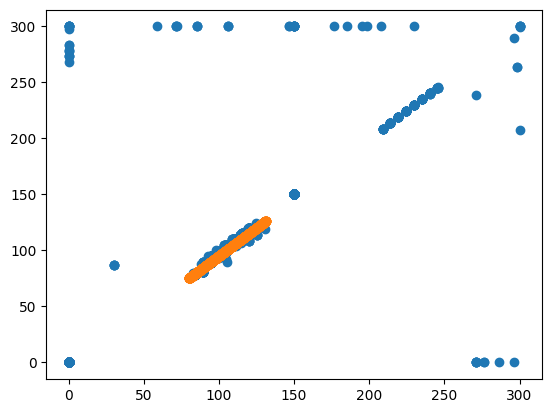

In [420]:
plt.scatter(predictions[:,0], predictions[:,1])
plt.scatter(pos_sub[:,0], pos_sub[:,1])

In [417]:
len(predictions)

1639

In [418]:
pos_sub.shape

(1639, 3)